# HoVer-Net

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision

In [1]:
%load_ext autoreload
%autoreload 2

In [566]:
# pannuke
from pathml.datasets.pannuke import PanNukeDataModule

pannuke = PanNukeDataModule(data_dir="./data/pannuke/", nucleus_type_labels=True, 
                            batch_size=4, hovernet_preprocess=True)
pannuke_train = pannuke.train_dataloader

In [574]:
im_batch, mask_batch, hv_batch, tissue_types_batch = next(iter(pannuke_train))

In [648]:
print(f"Im batch shape:\t\t{im_batch.shape}")
print(f"Mask batch shape:\t{mask_batch.shape}")
print(f"hv map batch shape:\t{hv_batch.shape}")

Im batch shape:		torch.Size([4, 3, 256, 256])
Mask batch shape:	torch.Size([4, 6, 256, 256])
hv map batch shape:	torch.Size([4, 2, 256, 256])


In [629]:
def vis_batch(im_batch, mask_batch, hv_batch, tissue_types_batch, n = 4):
    """
    visualize the inputs to HoVer-Net
    """
    fig, ax = plt.subplots(nrows = n, ncols= 5, figsize = (12, 3*n))
    
    for i in range(n):
        # image
        ax[i, 0].imshow(im_batch.permute(0, 2, 3, 1)[i, ...])
        # individual nuclei
        ax[i, 1].imshow(mask_batch.sum(dim=1)[i, ...])
        # nucleus types
        ax[i, 2].imshow(mask_batch.argmax(dim=1)[i, ...])
        ax[i, 3].imshow(hv_batch[i, 0, :, :], cmap = 'coolwarm')
        ax[i, 4].imshow(hv_batch[i, 1, :, :], cmap = 'coolwarm')
        
    ax[0, 0].set_title("RGB Image")
    ax[0, 1].set_title("Individual Nuclei")
    ax[0, 2].set_title("Nucleus Types")
    ax[0, 3].set_title("Horizontal Map")
    ax[0, 4].set_title("Vertical Map")
    for a in ax.ravel(): a.axis('off')
    
    plt.tight_layout()
    plt.show()

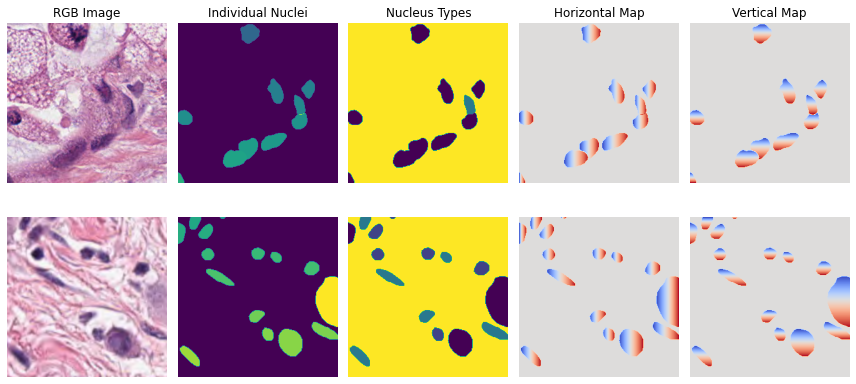

In [630]:
vis_batch(im_batch, mask_batch, hv_batch, tissue_types_batch, n = 2)

In [636]:
from pathml.ml.hovernet import get_gradient_hv

hg, vg = get_gradient_hv(hv_batch)
print(f"horizontal gradient shape:\t{hg.shape}")
print(f"vertical gradient shape:\t{vg.shape}")

horizontal gradient shape:	torch.Size([4, 1, 256, 256])
vertical gradient shape:	torch.Size([4, 1, 256, 256])


In [633]:
def vis_gradients(hv_batch, n=2):
    """
    Plot the horizontal, vertical maps alongside their gradients
    """
    hg, vg = get_gradient_hv(hv_batch)
    
    fix, axarr = plt.subplots(nrows=n, ncols=4, figsize = (10, 3*n))

    for i in range(n):
        axarr[i, 0].imshow(hv_batch[i, 0, ...], cmap = 'coolwarm')
        axarr[i, 1].imshow(hg[i, 0, ...], vmin=-2, vmax=2, cmap = 'coolwarm')
        axarr[i, 2].imshow(hv_batch[i, 1, ...], cmap = 'coolwarm')
        axarr[i, 3].imshow(vg[i, 0, ...], vmin=-2, vmax=2, cmap = 'coolwarm')
    
    axarr[0, 0].set_title("Horizontal Map")
    axarr[0, 1].set_title("Horizontal Gradients")
    axarr[0, 2].set_title("Vertical Map")
    axarr[0, 3].set_title("Vertical Gradients")
    for a in axarr.ravel(): a.axis('off')
    
    plt.tight_layout()
    plt.show()

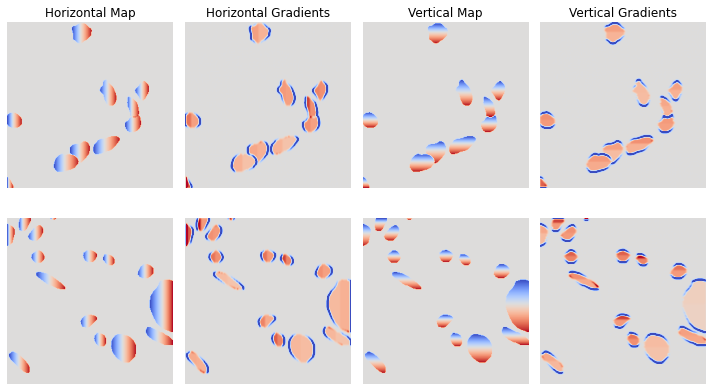

In [634]:
vis_gradients(hv_batch)

In [164]:
from pathml.ml.hovernet import HoverNet
hovernet = HoverNet(n_classes=6)

In [658]:
out = hovernet(im_batch.float())

torch.Size([4, 64, 256, 256])
torch.Size([4, 64, 256, 256])
torch.Size([4, 256, 256, 256])
torch.Size([4, 512, 128, 128])
torch.Size([4, 1024, 64, 64])
torch.Size([4, 2048, 32, 32])
torch.Size([4, 1024, 32, 32])
block 0 output shape: torch.Size([4, 256, 256, 256])
block 1 output shape: torch.Size([4, 512, 128, 128])
block 2 output shape: torch.Size([4, 1024, 64, 64])
block 3 output shape: torch.Size([4, 1024, 32, 32])
NP branch starting:
torch.Size([4, 1024, 64, 64])
torch.Size([4, 1024, 64, 64])
torch.Size([4, 256, 64, 64])
torch.Size([4, 512, 64, 64])
torch.Size([4, 512, 64, 64])
torch.Size([4, 512, 128, 128])
torch.Size([4, 512, 128, 128])
torch.Size([4, 128, 128, 128])
torch.Size([4, 256, 128, 128])
torch.Size([4, 256, 128, 128])
torch.Size([4, 256, 256, 256])
torch.Size([4, 256, 256, 256])
torch.Size([4, 64, 256, 256])
HV branch starting:
torch.Size([4, 1024, 64, 64])
torch.Size([4, 1024, 64, 64])
torch.Size([4, 256, 64, 64])
torch.Size([4, 512, 64, 64])
torch.Size([4, 512, 64, 64

In [659]:
np_out, hv_out, nc_out = out

In [660]:
print("input shapes")
for val, name in zip([im_batch, mask_batch], ["im", "mask"]):
    print(f"{name}:\t{val.shape}")
print("")
print("output shapes")
for val, name in zip(out, ["np_out", "hv_out", "nc_out"]):
    print(f"{name}:\t{val.shape}")

input shapes
im:	torch.Size([4, 3, 256, 256])
mask:	torch.Size([4, 6, 256, 256])

output shapes
np_out:	torch.Size([4, 2, 256, 256])
hv_out:	torch.Size([4, 2, 256, 256])
nc_out:	torch.Size([4, 6, 256, 256])


In [666]:
from pathml.ml.hovernet import loss_HoVerNet

loss = loss_HoVerNet(outputs = out, ground_truth = [mask_batch, hv_batch], n_classes=6)

print(f"loss for batch: {loss}")

loss for batch: 7.551418304443359
